<a href="https://colab.research.google.com/github/bboszori/data_science_tasks/blob/main/cnn_homework_bboszori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import keras
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
print(keras.__version__)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Create datasets

In [ ]:
TRAIN_PATH = '/content/gdrive/MyDrive/Data_Science_mentoring/11_nn/hotdog__not_hotdog/train'
TEST_PATH = '/content/gdrive/MyDrive/Data_Science_mentoring/11_nn/hotdog__not_hotdog/test'

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  crop_to_aspect_ratio = False,
  batch_size=BATCH_SIZE)

Found 498 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  crop_to_aspect_ratio = False,
  batch_size=BATCH_SIZE)

Found 500 files belonging to 2 classes.
Using 250 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  crop_to_aspect_ratio = False,
  batch_size=BATCH_SIZE)

Found 500 files belonging to 2 classes.
Using 250 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['hot_dog', 'not_hot_dog']


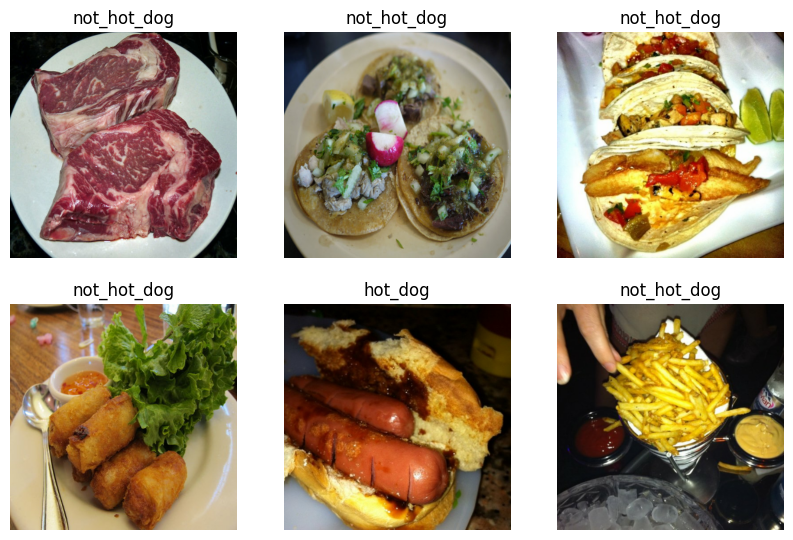

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 384, 384, 3)
(64,)


## Helper functions

In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=14)

In [ ]:
def plot_predictions(model):
  plt.figure(figsize=(15, 10))
  for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images),axis=1)
    for i in range(15):
      ax = plt.subplot(5, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(f'{class_names[labels[i]]} -> {class_names[preds[i]]}')
      plt.axis("off")

In [ ]:
def train_and_evaluate(train_ds, val_ds, model, num_epochs):
  model.build(input_shape=(BATCH_SIZE,IMG_WIDTH, IMG_HEIGHT, 3))
  model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

  print(model.summary())

  earlystop = EarlyStopping(patience=5)
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)
  callbacks = [earlystop, learning_rate_reduction]

  history = model.fit(
    x = train_ds, validation_data = val_ds,
    epochs=num_epochs,
    callbacks=callbacks)

  training_plot(['loss', 'accuracy'], history)

  acc = model.evaluate(test_ds)[1]
  print(f'Test Accuracy: {acc}')

  plot_predictions(model)

## Base CNN

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.build(input_shape=(BATCH_SIZE,IMG_WIDTH, IMG_HEIGHT, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 384, 384, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 382, 382, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 191, 191, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 189, 189, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 94, 94, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 92, 92, 32)          9

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
16/16 [==============================] - 57s 3s/step - loss: 1.1484 - accuracy: 0.5100 - val_loss: 0.7053 - val_accuracy: 0.5040
Epoch 2/5
16/16 [==============================] - 5s 276ms/step - loss: 0.6924 - accuracy: 0.5080 - val_loss: 0.6961 - val_accuracy: 0.5080
Epoch 3/5
16/16 [==============================] - 5s 226ms/step - loss: 0.6520 - accuracy: 0.6426 - val_loss: 0.6759 - val_accuracy: 0.5800
Epoch 4/5
16/16 [==============================] - 4s 204ms/step - loss: 0.6296 - accuracy: 0.6345 - val_loss: 0.6729 - val_accuracy: 0.5960
Epoch 5/5
16/16 [==============================] - 7s 352ms/step - loss: 0.5812 - accuracy: 0.6928 - val_loss: 0.7031 - val_accuracy: 0.6000


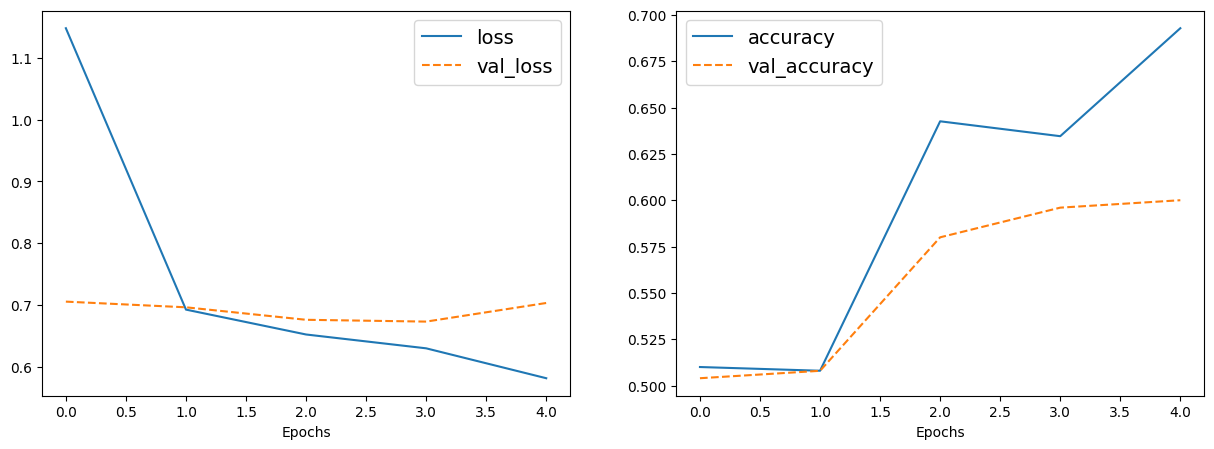

In [ ]:
training_plot(['loss', 'accuracy'], history)

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 48ms/step - loss: 0.7312 - accuracy: 0.5840


0.5839999914169312

1/1 [==============================] - 0s 163ms/step


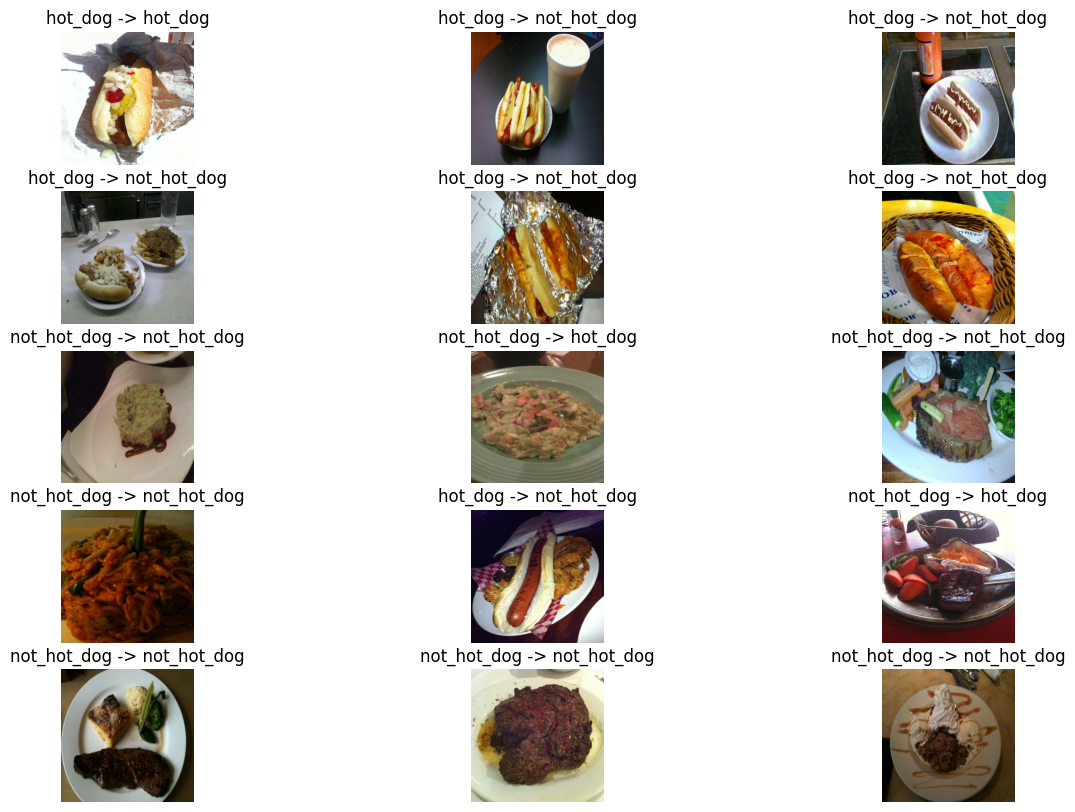

In [ ]:
plot_predictions(model)

## CNN with Batchnormalization & Dropout

In [ ]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
layer_rescale = [tf.keras.layers.Rescaling(1./255)]
layers_conv = [
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.SpatialDropout2D(0.2)
]
layers_dense = [
    tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(num_classes)
]

In [ ]:
layers = layer_rescale + layers_conv + layers_dense

In [ ]:
m_reg = tf.keras.Sequential(layers)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 384, 384, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 382, 382, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (32, 382, 382, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 191, 191, 32)        0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_2 (Spati  (32, 191, 191, 32)        0         
 alDropout2D)                                                    
                                                      

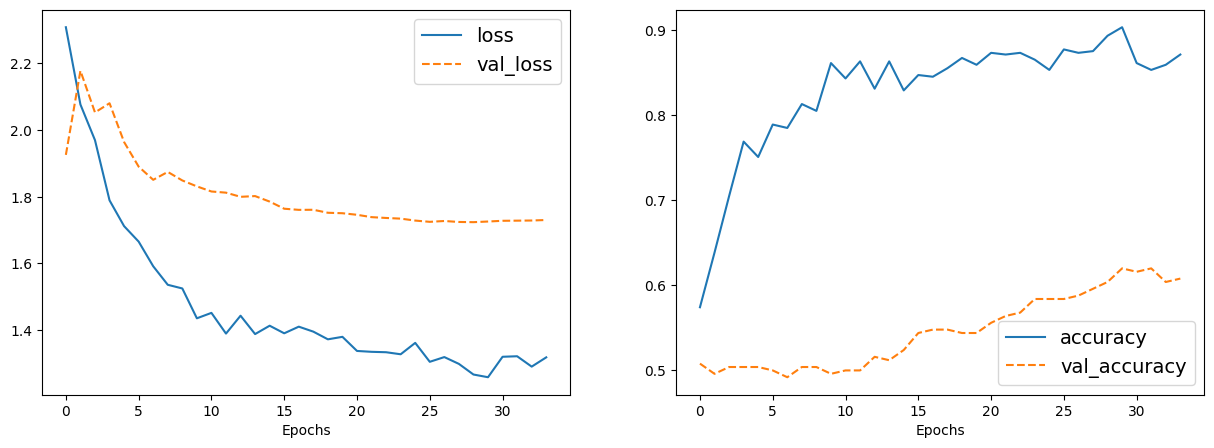

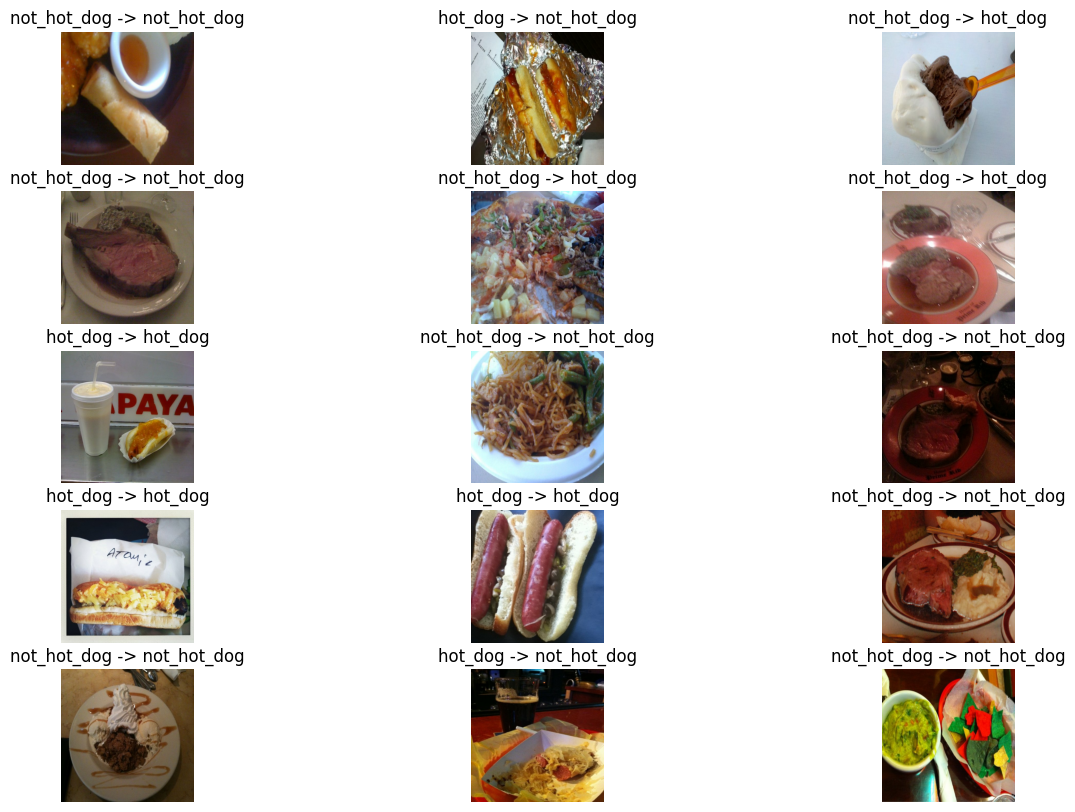

In [ ]:
train_and_evaluate(train_ds, val_ds, m_reg, 100)

## CNN with batch normalization

In [ ]:
layers_conv_bn = [
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D()
]
layers_dense_bn = [
    tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes)
]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (32, 382, 382, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (32, 382, 382, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 191, 191, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 189, 189, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (32, 189, 189, 32)       

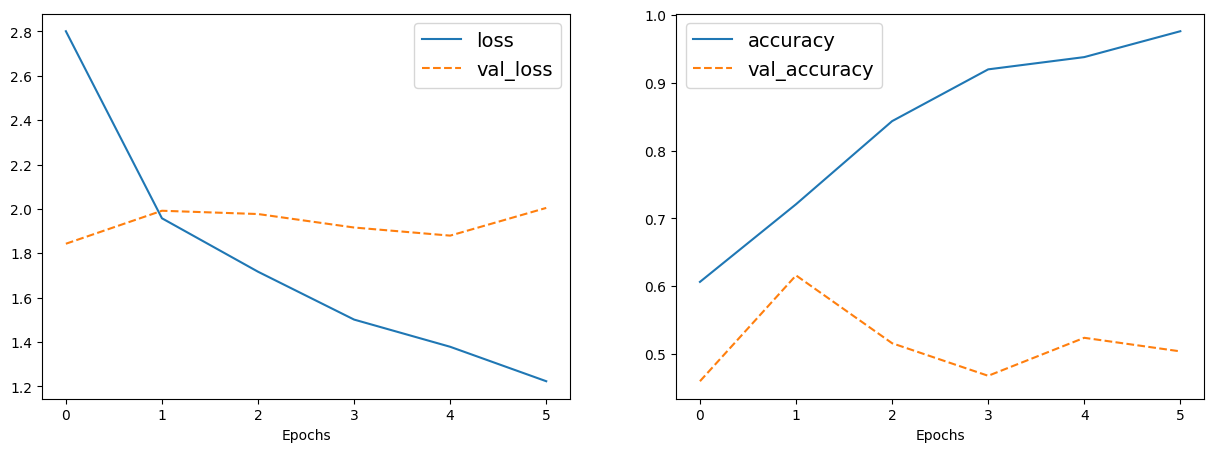

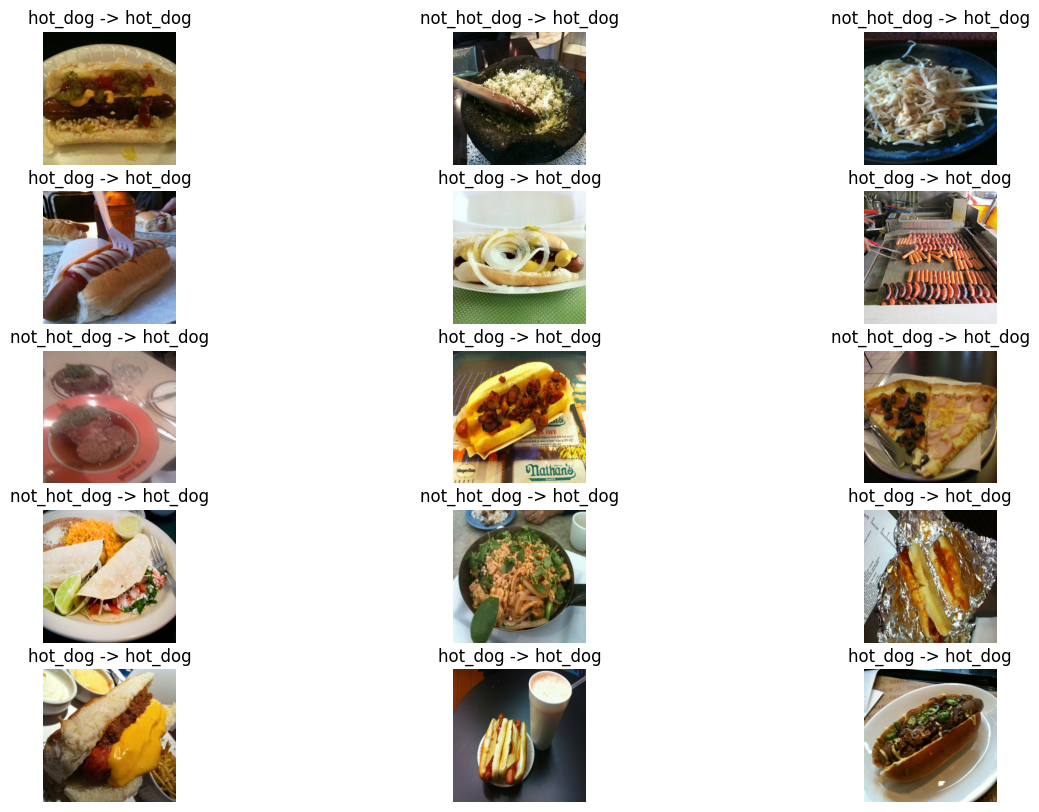

In [ ]:
layers = layer_rescale + layers_conv_bn + layers_dense_bn
m_bn = tf.keras.Sequential(layers)
train_and_evaluate(train_ds, val_ds, m_bn, 100)

## CNN with Dropout layers

In [ ]:
layers_conv_do = [
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.SpatialDropout2D(0.2)
]
layers_dense_do = [
    tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(num_classes)
]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           (32, 382, 382, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 191, 191, 32)        0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_2 (Spati  (32, 191, 191, 32)        0         
 alDropout2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (32, 189, 189, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 94, 94, 32)         

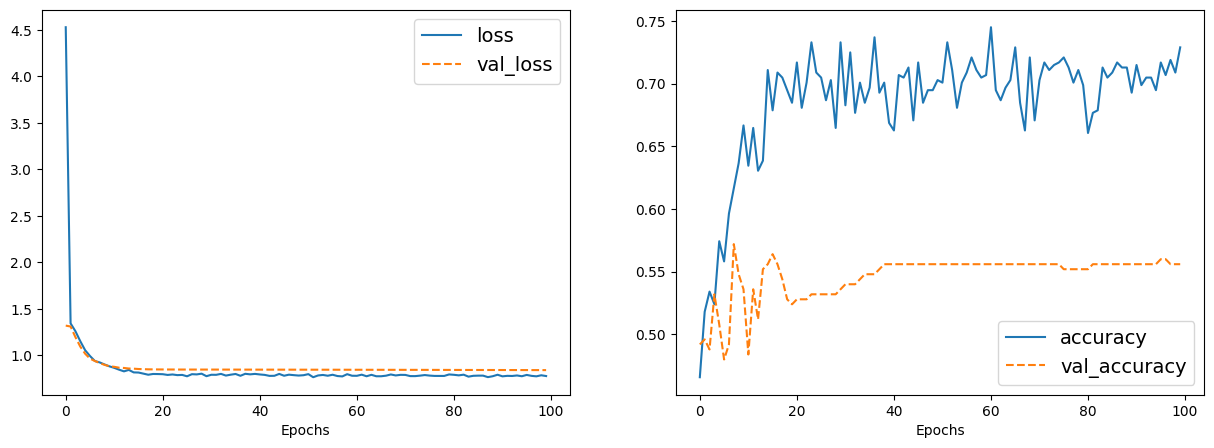

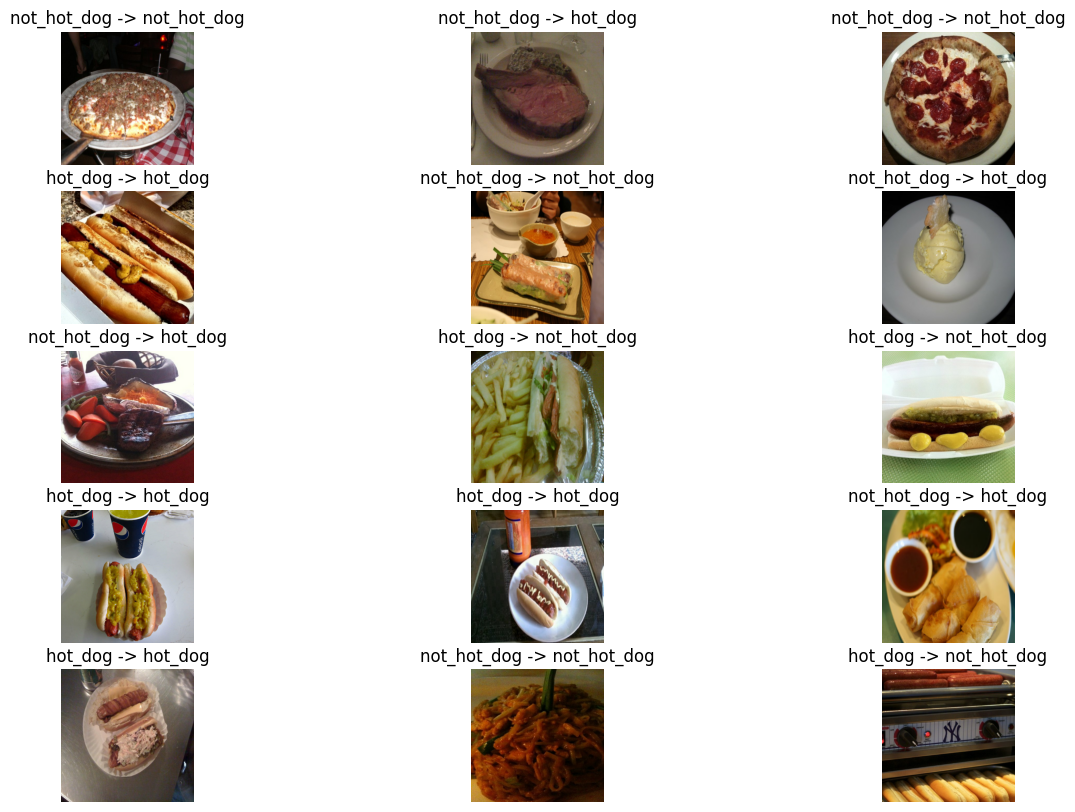

In [ ]:
layers = layer_rescale + layers_conv_do + layers_dense_do
m_do = tf.keras.Sequential(layers)
train_and_evaluate(train_ds, val_ds, m_do, 100)

## Data augmentation

In [ ]:
layers_da = [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
]

In [ ]:
layers = layer_rescale + layers_da + layers_conv + layers_dense

In [ ]:
m_da = tf.keras.Sequential(layers)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 random_flip (RandomFlip)    (32, 384, 384, 3)         0         
                                                                 
 random_rotation (RandomRot  (32, 384, 384, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (32, 384, 384, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           multiple                  896       
                                                                 
 batch_normalization_3 (Bat  multiple                  128       
 chNormalization)                                     

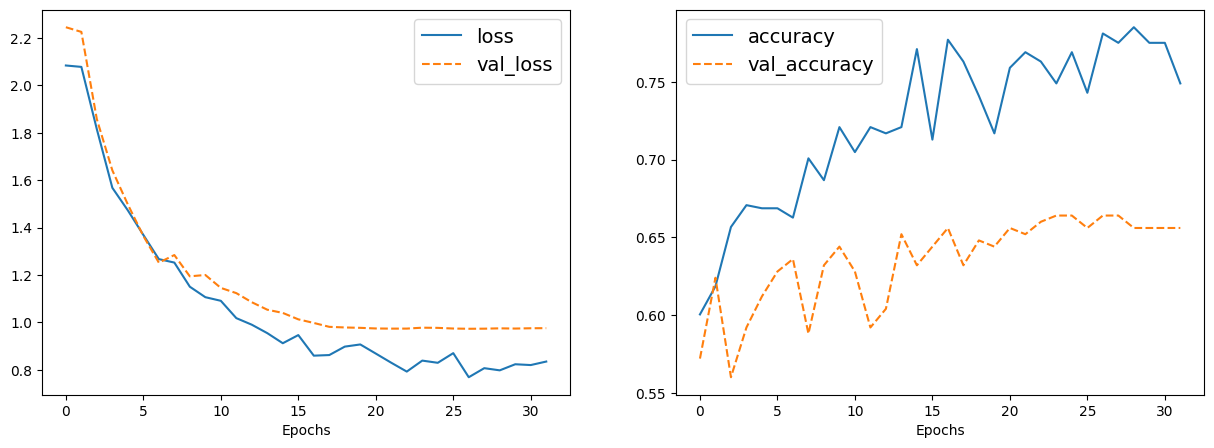

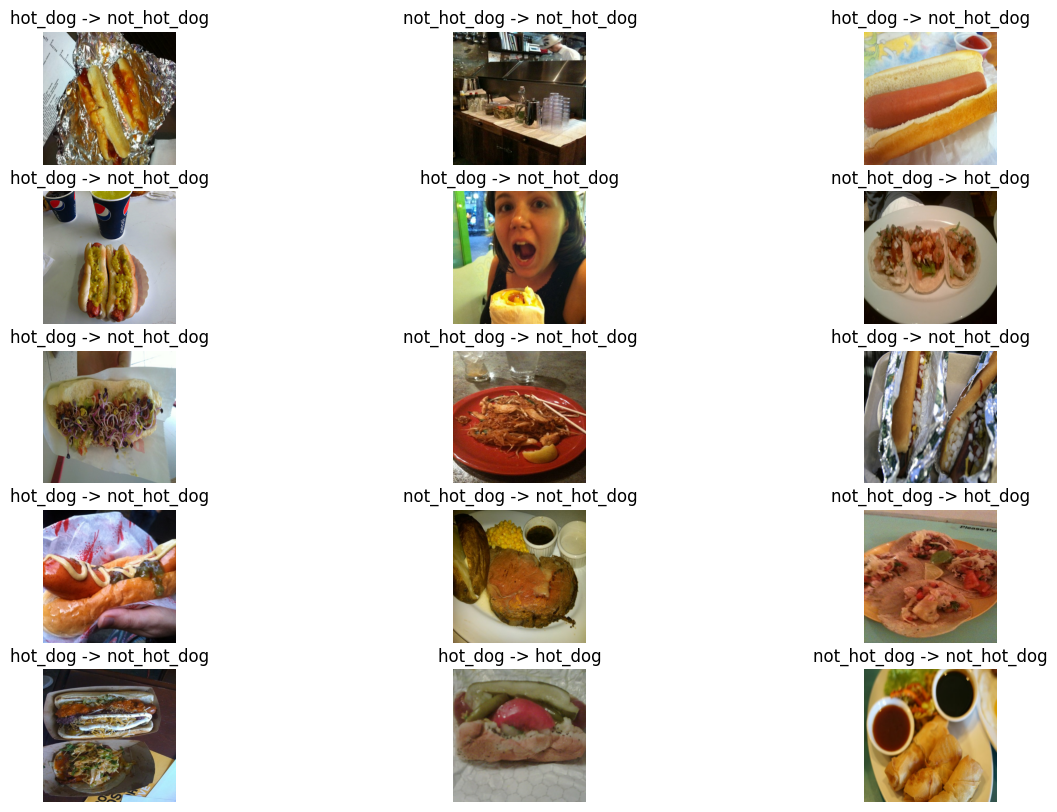

In [ ]:
train_and_evaluate(train_ds, val_ds, m_da, 100)

## Transfer learning with VGG19

In [ ]:
layers = layer_rescale + layers_da
data_augmentation = tf.keras.Sequential(layers)

In [ ]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
base_model_vgg19.trainable = False

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = base_model_vgg19(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 384, 384, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 tf.__operators__.getitem_8  (None, 384, 384, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 384, 384, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 12, 12, 512)       20024384  
                                                                 
 flatten_9 (Flatten)         (None, 73728)             0     

1/1 [==============================] - 0s 294ms/step


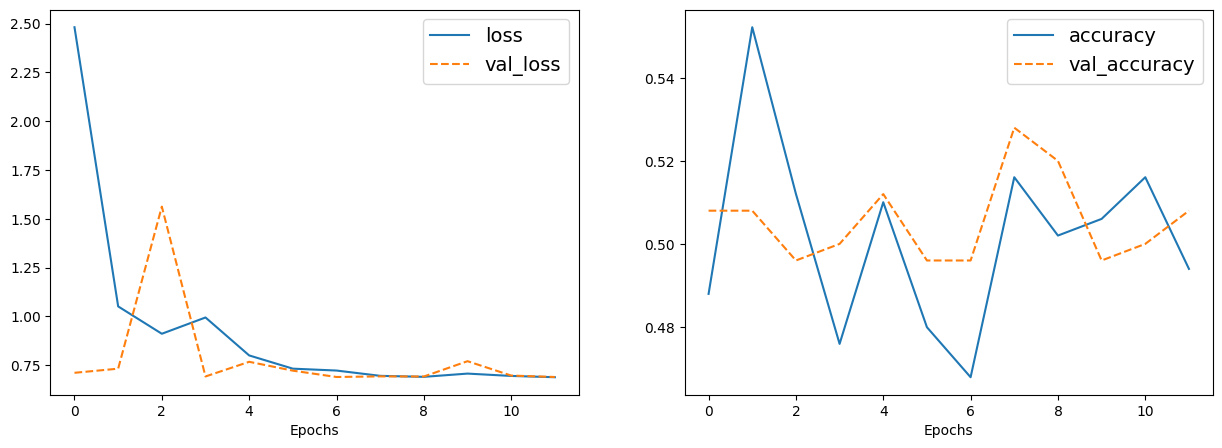

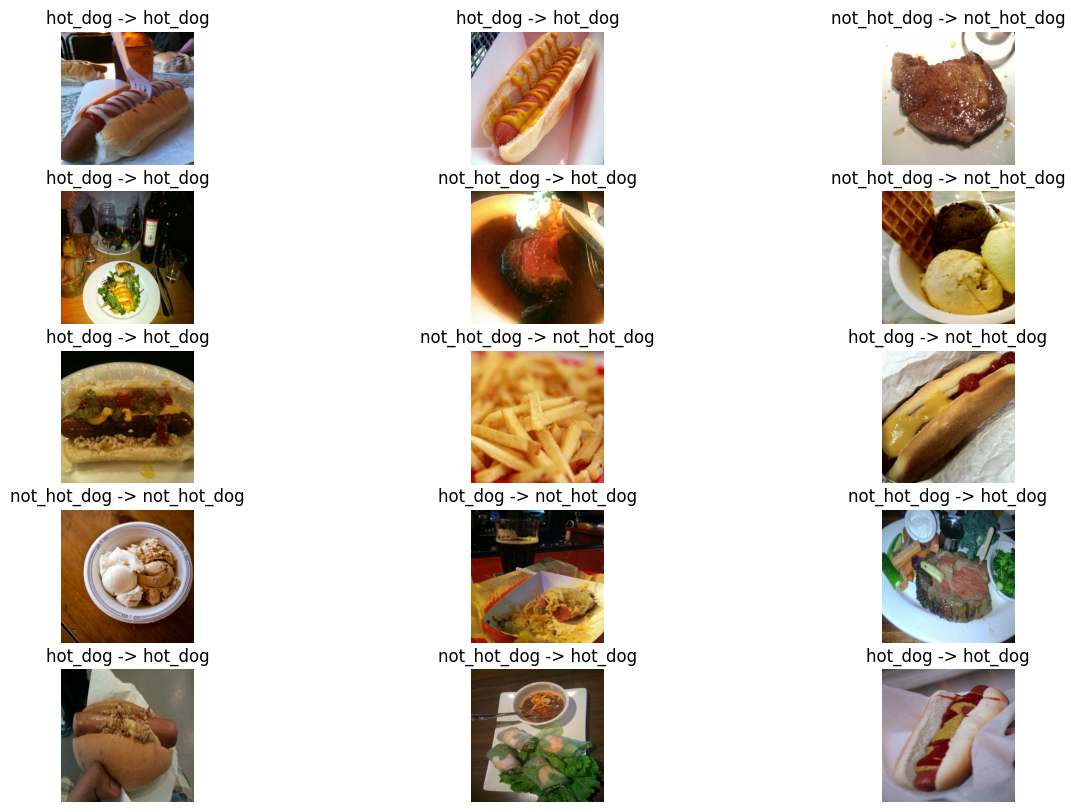

In [ ]:
train_and_evaluate(train_ds, val_ds, model_vgg19, 20)

## Transfer learning with Inception_v3

In [ ]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [ ]:
layer_inc = [hub.KerasLayer(inception_v3, trainable=False),
             tf.keras.layers.Dense(num_classes)]

In [ ]:
layers = layer_rescale + layers_da + layer_inc
m_inc = tf.keras.Sequential(layers)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 random_flip (RandomFlip)    multiple                  0         
                                                                 
 random_rotation (RandomRot  multiple                  0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    multiple                  0         
                                                                 
 keras_layer (KerasLayer)    (32, 1001)                23853833  
                                                                 
 dense_6 (Dense)             (32, 2)                   2004      
                                                      

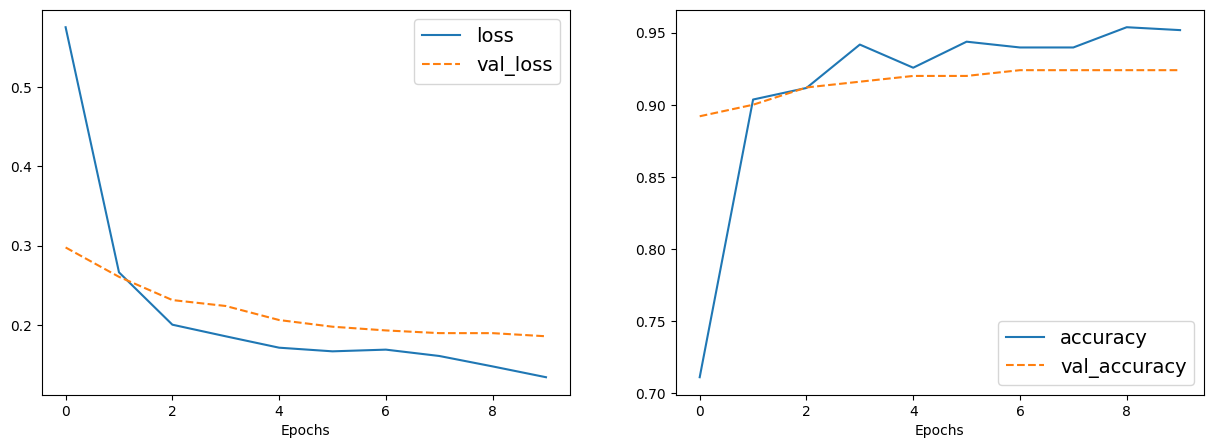

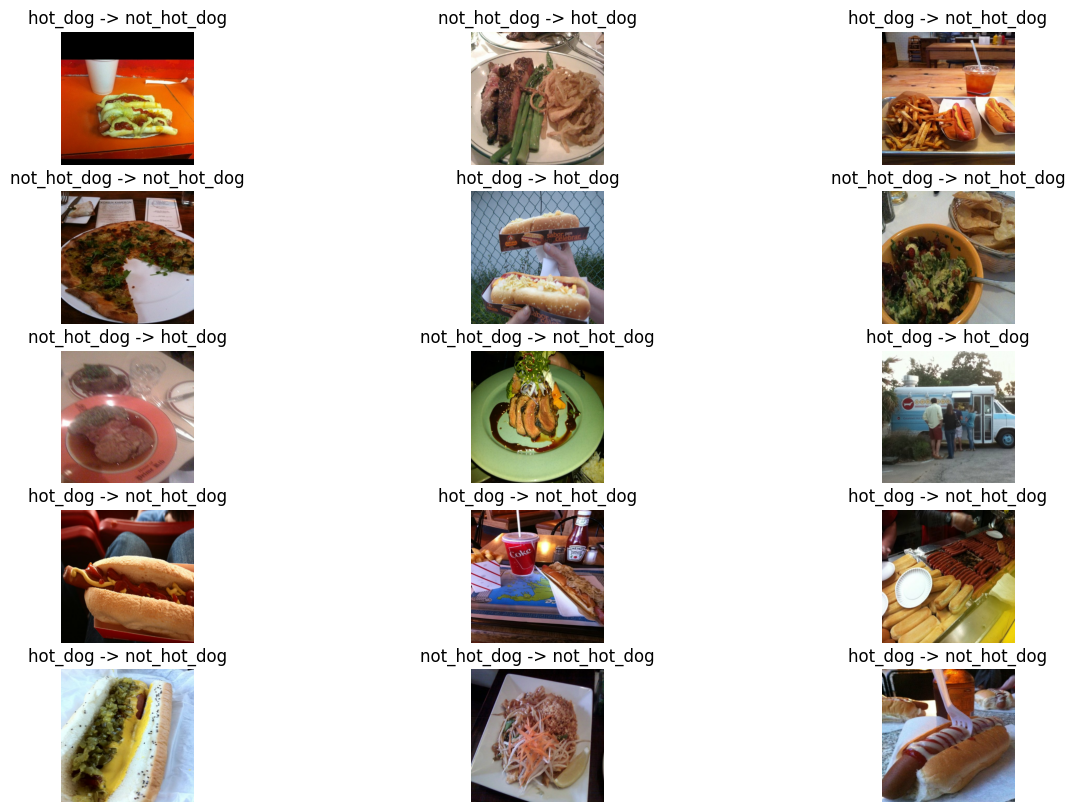

In [ ]:
train_and_evaluate(train_ds, val_ds, m_inc, 10)

## Transfer learning with Inception_v3 + fine tuning

In [ ]:
layer_inc_ft = [hub.KerasLayer(inception_v3, trainable=True),
             tf.keras.layers.Dense(num_classes)]

In [ ]:
layers = layer_rescale + layers_da + layer_inc_ft
m_inc_ft = tf.keras.Sequential(layers)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 random_flip (RandomFlip)    multiple                  0         
                                                                 
 random_rotation (RandomRot  multiple                  0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    multiple                  0         
                                                                 
 keras_layer_1 (KerasLayer)  (32, 1001)                23853833  
                                                                 
 dense_7 (Dense)             (32, 2)                   2004      
                                                      

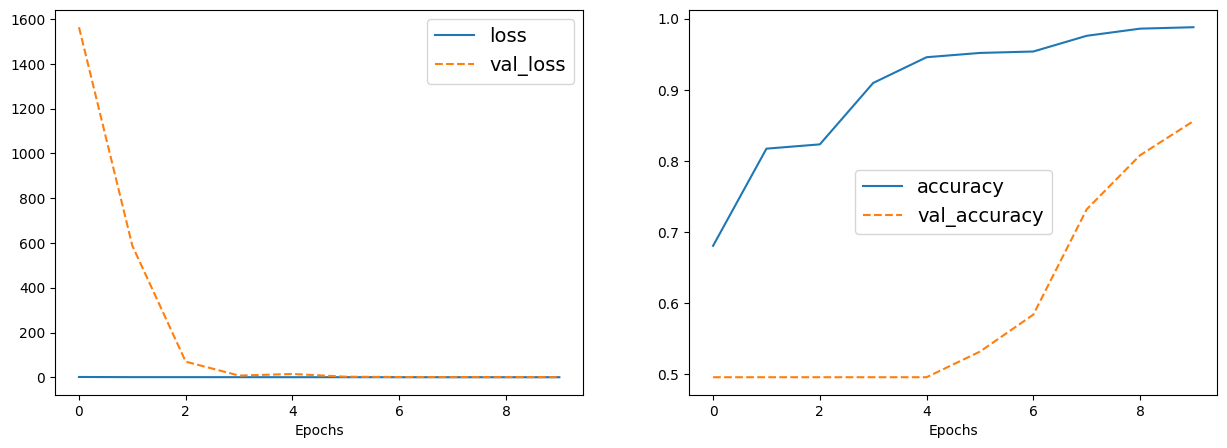

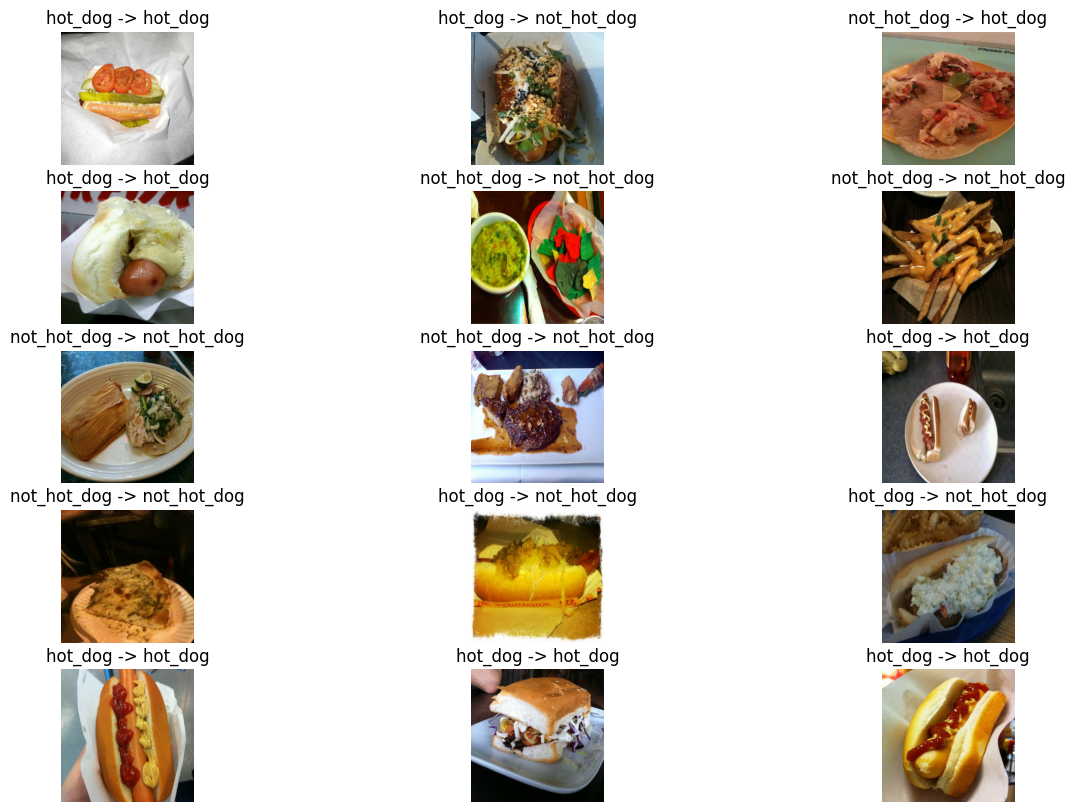

In [ ]:
train_and_evaluate(train_ds, val_ds, m_inc_ft, 10)

## Transfer learning with Resnet50

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 498 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 500 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['hot_dog', 'not_hot_dog']


In [ ]:
def data_augmentation(inputs, flip_probability=0.5, rotation_range=20, zoom_range=0.2):
    inputs = tf.keras.layers.RandomFlip(mode='horizontal')(inputs, training=True)
    inputs = tf.keras.layers.RandomRotation(factor=rotation_range)(inputs, training=True)
    inputs = tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range)(inputs, training=True)

    return inputs

In [ ]:
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
base_model_resnet50.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model_resnet50(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet50 = tf.keras.Model(inputs, outputs, name='resnet50')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model_resnet50.build(input_shape=(BATCH_SIZE,IMG_WIDTH, IMG_HEIGHT, 3))

In [ ]:
model_resnet50.layers[-3].summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[keras.metrics.BinaryAccuracy()])

print(model_resnet50.summary())

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 256, 256, 3)       0  

In [ ]:
history = model_resnet50.fit(
    x = train_ds, validation_data = val_ds,
    epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 14s 561ms/step - loss: 0.5612 - binary_accuracy: 0.7028 - val_loss: 0.5062 - val_binary_accuracy: 0.7400
Epoch 2/20
16/16 [==============================] - 6s 341ms/step - loss: 0.4001 - binary_accuracy: 0.8293 - val_loss: 0.3734 - val_binary_accuracy: 0.8460
Epoch 3/20
16/16 [==============================] - 9s 436ms/step - loss: 0.3031 - binary_accuracy: 0.8755 - val_loss: 0.3372 - val_binary_accuracy: 0.8660
Epoch 4/20
16/16 [==============================] - 8s 482ms/step - loss: 0.2727 - binary_accuracy: 0.8835 - val_loss: 0.3171 - val_binary_accuracy: 0.8560
Epoch 5/20
16/16 [==============================] - 6s 342ms/step - loss: 0.2502 - binary_accuracy: 0.9177 - val_loss: 0.3019 - val_binary_accuracy: 0.8780
Epoch 6/20
16/16 [==============================] - 8s 474ms/step - loss: 0.2321 - binary_accuracy: 0.9137 - val_loss: 0.2731 - val_binary_accuracy: 0.8960
Epoch 7/20
16/16 [==============================] - 6s 335ms/step - loss: 

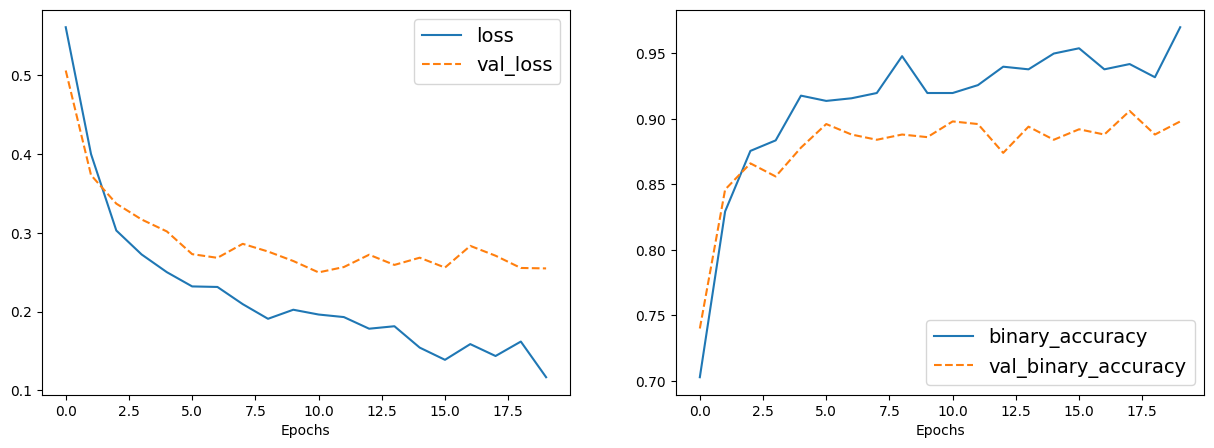

In [ ]:
training_plot(['loss', 'binary_accuracy'], history)

In [ ]:
base_model_resnet50.trainable = True
model_resnet50.summary(show_trainable=True)

model_resnet50.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model_resnet50.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "resnet50"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 image (InputLayer)          [(None, 256, 256, 3)]     0         Y          
                                                                            
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         Y          
                                                                            
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         Y          
 otation)                                                                   
                                                                            
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         Y          
                                                                            
 tf.__operators__.getitem_1  (None, 256, 256, 3)       0         Y          
  (SlicingOpLambda)                                       